<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/Stock_NeurIPS2018_SB3.py">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version**



<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Python Packages

<a id='1.3'></a>
## 2.1. Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from stable_baselines3.common.policies import ActorCriticPolicy

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

import torch

/home/duc/.conda/envs/trading/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


<a id='1.4'></a>
## 2.2. Create Folders

In [2]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [3]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [4]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-03-01'

In [5]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [6]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [7]:
df.shape

(97013, 8)

In [8]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.478997,493729600,AAPL,0
1,2010-01-04,56.630001,57.869999,56.560001,41.817783,5277400,AMGN,0
2,2010-01-04,40.810001,41.099998,40.389999,33.300198,6894300,AXP,0
3,2010-01-04,55.720001,56.389999,54.799999,43.777550,6186700,BA,0
4,2010-01-04,57.650002,59.189999,57.509998,40.523613,7325600,CAT,0


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [9]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (3310, 8)
Successfully added vix
Successfully added turbulence index


In [10]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [11]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,AAPL,7.622500,7.660714,7.585000,6.478997,493729600.0,0.0,0.0,6.50044,6.468755,100.0,66.666667,100.0,6.478997,6.478997,20.040001,0.0
1,2010-01-04,AMGN,56.630001,57.869999,56.560001,41.817783,5277400.0,0.0,0.0,6.50044,6.468755,100.0,66.666667,100.0,41.817783,41.817783,20.040001,0.0
2,2010-01-04,AXP,40.810001,41.099998,40.389999,33.300198,6894300.0,0.0,0.0,6.50044,6.468755,100.0,66.666667,100.0,33.300198,33.300198,20.040001,0.0
3,2010-01-04,BA,55.720001,56.389999,54.799999,43.777550,6186700.0,0.0,0.0,6.50044,6.468755,100.0,66.666667,100.0,43.777550,43.777550,20.040001,0.0
4,2010-01-04,CAT,57.650002,59.189999,57.509998,40.523613,7325600.0,0.0,0.0,6.50044,6.468755,100.0,66.666667,100.0,40.523613,40.523613,20.040001,0.0
5,2010-01-04,CRM,18.652500,18.882500,18.547501,18.705000,7906000.0,0.0,0.0,6.50044,6.468755,100.0,66.666667,100.0,18.705000,18.705000,20.040001,0.0
6,2010-01-04,CSCO,24.110001,24.840000,24.010000,17.011656,59853700.0,0.0,0.0,6.50044,6.468755,100.0,66.666667,100.0,17.011656,17.011656,20.040001,0.0
7,2010-01-04,CVX,78.199997,79.199997,78.160004,45.479145,10173800.0,0.0,0.0,6.50044,6.468755,100.0,66.666667,100.0,45.479145,45.479145,20.040001,0.0
8,2010-01-04,DIS,32.500000,32.750000,31.870001,27.933918,13700400.0,0.0,0.0,6.50044,6.468755,100.0,66.666667,100.0,27.933918,27.933918,20.040001,0.0
9,2010-01-04,GS,170.050003,174.250000,169.509995,136.536911,9135000.0,0.0,0.0,6.50044,6.468755,100.0,66.666667,100.0,136.536911,136.536911,20.040001,0.0


In [12]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [13]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

85753
10237


In [14]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2956,2021-09-30,UNH,401.489990,403.489990,390.459991,380.133820,3779900.0,3.0,-4.314674,415.879433,383.788148,40.895411,-222.863074,41.980385,402.720105,402.215105,23.139999,24.872138
2956,2021-09-30,V,227.580002,228.789993,222.630005,218.950439,7128500.0,3.0,-1.529597,227.282224,215.244417,44.078976,-54.549949,19.569853,223.443159,230.105520,23.139999,24.872138
2956,2021-09-30,VZ,54.500000,54.509998,54.000000,47.143322,18736600.0,3.0,-0.224760,48.220257,46.886009,41.824927,-102.563602,21.682953,47.714176,48.219709,23.139999,24.872138
2956,2021-09-30,WBA,48.790001,48.930000,46.919998,41.550095,6449400.0,3.0,-0.239655,45.874108,41.209769,44.613721,-106.872802,0.941150,43.373707,42.401281,23.139999,24.872138
2956,2021-09-30,WMT,140.639999,141.729996,139.250000,135.119339,7485900.0,3.0,-1.543464,145.086234,134.641201,40.165889,-151.522402,45.466733,141.304293,140.213741,23.139999,24.872138


In [15]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-10-01,AAPL,141.899994,142.919998,139.110001,140.832993,94639600.0,4.0,-1.696603,154.755086,136.578169,46.927741,-142.213973,41.749873,146.577216,145.678476,21.1,120.123744
0,2021-10-01,AMGN,213.589996,214.610001,210.800003,198.754761,2629400.0,4.0,-3.019972,207.454030,194.400020,40.408565,-96.918795,36.189244,203.273949,211.681106,21.1,120.123744
0,2021-10-01,AXP,168.500000,175.119995,168.479996,168.790695,3956000.0,4.0,2.256291,172.913030,148.114336,56.265123,117.483592,15.667511,160.007295,162.233704,21.1,120.123744
0,2021-10-01,BA,222.850006,226.720001,220.600006,226.000000,9113600.0,4.0,0.730320,226.909442,205.727561,51.614047,116.649440,2.027170,217.175334,221.968500,21.1,120.123744
0,2021-10-01,CAT,192.899994,195.869995,191.240005,185.036270,3695500.0,4.0,-3.584308,202.570121,178.640957,41.999445,-112.141367,36.203176,193.962593,197.436541,21.1,120.123744


In [16]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [17]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [18]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [19]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Part 6: Train Custom DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [20]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
# hyperparameters
hidden_size = 256
learning_rate = 3e-4

In [22]:
import torch as th
from typing import Optional, Union, List, Dict, Type, Any
from gymnasium import spaces
from stable_baselines3.common.type_aliases import PyTorchObs, Schedule
from stable_baselines3.common.torch_layers import (
    BaseFeaturesExtractor,
    CombinedExtractor,
    FlattenExtractor,
    MlpExtractor,
    NatureCNN,
    create_mlp,
)

In [23]:
# Constants
GAMMA = 0.99
num_steps = 300
max_episodes = 3000

In [33]:
def calc_Lout(length_in, kernel_size, stride=1, padding=0, dilation=1):
    return (length_in + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

In [60]:
import torch.nn as nn
import torch.distributions as distributions
from stable_baselines3.common.policies import ActorCriticPolicy

class CustomA2CPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        lr_schedule: Schedule,
        net_arch: Optional[Union[List[int], Dict[str, List[int]]]] = None,
        activation_fn: Type[nn.Module] = nn.Tanh,
        ortho_init: bool = True,
        use_sde: bool = False,
        log_std_init: float = 0.0,
        full_std: bool = True,
        use_expln: bool = False,
        squash_output: bool = False,
        features_extractor_class: Type[BaseFeaturesExtractor] = FlattenExtractor,
        features_extractor_kwargs: Optional[Dict[str, Any]] = None,
        share_features_extractor: bool = True,
        normalize_images: bool = True,
        optimizer_class: Type[th.optim.Optimizer] = th.optim.Adam,
        optimizer_kwargs: Optional[Dict[str, Any]] = None,
    ):
        super().__init__(
            observation_space,
            action_space,
            lr_schedule,
            net_arch,
            activation_fn,
            ortho_init,
            use_sde,
            log_std_init,
            full_std,
            use_expln,
            squash_output,
            features_extractor_class,
            features_extractor_kwargs,
            share_features_extractor,
            normalize_images,
            optimizer_class,
            optimizer_kwargs,
        )

        # Define your custom neural network architecture here
        self.actor = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 35, 64),
            nn.ReLU(),
            nn.Linear(64, action_space.shape[0]),
            nn.Tanh()  # Tanh activation for continuous actions
        )

        self.critic = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 35, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, obs, deterministic=False):
        features = self.features_extractor(obs).unsqueeze(0)
        # print(features.shape)
        values = self.critic(features)
        # print(values.shape)
        
        if deterministic:
            actions = self.actor(features)
            log_probs = None  # Set log_probs to None for deterministic actions
        else:
            action_mean = self.actor(features)
            action_std = torch.ones_like(action_mean)  # Replace with appropriate action_std logic
            dist = distributions.Normal(action_mean, action_std)
            actions = dist.sample()
            log_probs = dist.log_prob(actions)

        if log_probs is not None:
            log_probs = torch.sum(log_probs, dim=-1)  # Sum log_probs along the action dimensions

        # print(actions.shape, values.shape, log_probs.shape)
        return actions, values, log_probs  # Return actions, values, and log_probs


In [72]:
# Define network architecture and device
custom_net_arch = [64, 64]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create an A2C agent with the custom policy
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c", policy=CustomA2CPolicy, policy_kwargs={"net_arch": custom_net_arch}, model_kwargs={'device':'cpu'})

# Train the agent
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000)


{'device': 'cpu'}
Using cpu device
--------------------------------------
| time/                 |            |
|    fps                | 128        |
|    iterations         | 100        |
|    time_elapsed       | 3          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -40.8      |
|    explained_variance | 0.303      |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -205       |
|    reward             | 0.20125647 |
|    std                | 0.989      |
|    value_loss         | 0.731      |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 130         |
|    iterations         | 200         |
|    time_elapsed       | 7           |
|    total_timesteps    | 1000        |
| train/                |             |
|    entropy_loss       | -41.2       |
|    explained_varian

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [20]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [21]:
insample_risk_indicator.vix.describe()

count    2957.000000
mean       18.105293
std         7.272476
min         9.140000
25%        13.370000
50%        16.209999
75%        20.629999
max        82.690002
Name: vix, dtype: float64

In [22]:
insample_risk_indicator.vix.quantile(0.996)

57.212001831054636

In [23]:
insample_risk_indicator.turbulence.describe()

count    2957.000000
mean       34.139590
std        43.879114
min         0.000000
25%        14.613476
50%        23.644001
75%        38.292745
max       652.505736
Name: turbulence, dtype: float64

In [24]:
insample_risk_indicator.turbulence.quantile(0.996)

291.72402810257574

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [25]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [26]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-10-01,AAPL,141.899994,142.919998,139.110001,140.832993,94639600.0,4.0,-1.696603,154.755086,136.578169,46.927741,-142.213973,41.749873,146.577216,145.678476,21.1,120.123744
0,2021-10-01,AMGN,213.589996,214.610001,210.800003,198.754761,2629400.0,4.0,-3.019972,207.454030,194.400020,40.408565,-96.918795,36.189244,203.273949,211.681106,21.1,120.123744
0,2021-10-01,AXP,168.500000,175.119995,168.479996,168.790695,3956000.0,4.0,2.256291,172.913030,148.114336,56.265123,117.483592,15.667511,160.007295,162.233704,21.1,120.123744
0,2021-10-01,BA,222.850006,226.720001,220.600006,226.000000,9113600.0,4.0,0.730320,226.909442,205.727561,51.614047,116.649440,2.027170,217.175334,221.968500,21.1,120.123744
0,2021-10-01,CAT,192.899994,195.869995,191.240005,185.036270,3695500.0,4.0,-3.584308,202.570121,178.640957,41.999445,-112.141367,36.203176,193.962593,197.436541,21.1,120.123744


In [ ]:
trained_moedl = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

In [74]:
df_account_value_a2c

,date,account_value
0,2021-10-01,1.000000e+06
1,2021-10-04,9.986853e+05
2,2021-10-05,1.001101e+06
3,2021-10-06,1.002687e+06
4,2021-10-07,1.009896e+06
...,...,...
348,2023-02-21,1.052475e+06
349,2023-02-22,1.049211e+06
350,2023-02-23,1.050809e+06
351,2023-02-24,1.045834e+06


In [41]:
df_account_value_a2c.shape

(353, 2)

<a id='7'></a>
# Part 6.5: Mean Variance Optimization

In [28]:
mvo_df.head()

,date,tic,close
0,2010-01-04,AAPL,6.478997
1,2010-01-04,AMGN,41.817783
2,2010-01-04,AXP,33.300198
3,2010-01-04,BA,43.777550
4,2010-01-04,CAT,40.523613


In [29]:
fst = mvo_df
fst = fst.iloc[0*29:0*29+29, :]
tic = fst['tic'].tolist()

mvo = pd.DataFrame()

for k in range(len(tic)):
  mvo[tic[k]] = 0

for i in range(mvo_df.shape[0]//29):
  n = mvo_df
  n = n.iloc[i*29:i*29+29, :]
  date = n['date'][i*29]
  mvo.loc[date] = n['close'].tolist()

In [30]:
mvo.shape[0]

3310

### Helper functions

In [31]:
from scipy import optimize
from scipy.optimize import linprog

#function obtains maximal return portfolio using linear programming

def MaximizeReturns(MeanReturns, PortfolioSize):

  #dependencies


  c = (np.multiply(-1, MeanReturns))
  A = np.ones([PortfolioSize,1]).T
  b=[1]
  res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex')

  return res

def MinimizeRisk(CovarReturns, PortfolioSize):

  def f(x, CovarReturns):
    func = np.matmul(np.matmul(x, CovarReturns), x.T)
    return func

  def constraintEq(x):
    A=np.ones(x.shape)
    b=1
    constraintVal = np.matmul(A,x.T)-b
    return constraintVal

  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq})
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = 10**-3)

  return opt

def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):

  def  f(x,CovarReturns):

    func = np.matmul(np.matmul(x,CovarReturns ), x.T)
    return func

  def constraintEq(x):
    AEq=np.ones(x.shape)
    bEq=1
    EqconstraintVal = np.matmul(AEq,x.T)-bEq
    return EqconstraintVal

  def constraintIneq(x, MeanReturns, R):
    AIneq = np.array(MeanReturns)
    bIneq = R
    IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
    return IneqconstraintVal


  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq},
          {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                x0 = xinit,   bounds = bnds, constraints = cons, tol = 10**-3)

  return opt

In [32]:
def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

### Calculate mean returns and variance-covariance matrix

In [33]:
# Obtain optimal portfolio sets that maximize return and minimize risk

#Dependencies
import numpy as np
import pandas as pd


#input k-portfolio 1 dataset comprising 15 stocks
# StockFileName = './DJIA_Apr112014_Apr112019_kpf1.csv'

Rows = 1259  #excluding header
Columns = 15  #excluding date
portfolioSize = 29 #set portfolio size

#read stock prices in a dataframe
# df = pd.read_csv(StockFileName,  nrows= Rows)

#extract asset labels
# assetLabels = df.columns[1:Columns+1].tolist()
# print(assetLabels)

#extract asset prices
# StockData = df.iloc[0:, 1:]
StockData = mvo.head(mvo.shape[0]-336)
TradeData = mvo.tail(336)
# df.head()
TradeData.to_numpy()


array([[147.41802979, 193.88624573, 176.02966309, ...,  46.88179398,
         42.66280746, 144.20289612],
       [146.95401001, 191.93513489, 173.1890564 , ...,  46.4843483 ,
         41.61191559, 143.02017212],
       [150.62664795, 192.48329163, 169.86203003, ...,  46.63449097,
         41.59424973, 143.91207886],
       ...,
       [148.79640198, 231.68534851, 173.1856842 , ...,  36.45794296,
         34.22706604, 140.4750824 ],
       [146.11727905, 227.82426453, 172.30558777, ...,  36.65665054,
         33.8395195 , 140.85076904],
       [147.3223877 , 228.5945282 , 171.36621094, ...,  36.78911972,
         33.45196915, 139.83248901]])

In [34]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)


#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)


Mean returns of assets in k-portfolio 1
 [0.121 0.063 0.073 0.078 0.069 0.118 0.052 0.043 0.073 0.052 0.106 0.078
 0.022 0.057 0.049 0.073 0.04  0.063 0.046 0.05  0.098 0.096 0.046 0.059
 0.109 0.095 0.042 0.035 0.051]
Variance-Covariance matrix of returns
 [[3.128 1.014 1.29  1.521 1.371 1.689 1.375 1.125 1.088 1.374 1.163 1.221
  1.03  1.525 0.692 1.269 0.664 0.816 1.029 0.733 1.576 1.139 0.668 0.86
  1.144 1.338 0.525 0.908 0.635]
 [1.014 2.4   1.072 1.01  1.066 1.211 1.025 0.965 0.937 1.122 0.978 1.029
  0.851 1.153 0.891 1.14  0.641 0.664 0.906 1.072 1.088 0.873 0.724 0.854
  1.146 1.056 0.631 1.025 0.645]
 [1.29  1.072 3.315 2.475 1.907 1.568 1.428 1.922 1.715 2.237 1.376 1.847
  1.343 1.508 0.861 2.37  0.99  1.075 1.375 0.964 1.357 1.418 0.728 1.505
  1.417 1.8   0.748 1.216 0.584]
 [1.521 1.01  2.475 4.962 2.117 1.687 1.511 2.143 1.838 2.201 1.527 2.121
  1.532 1.699 0.905 2.296 1.117 1.195 1.461 0.949 1.437 1.573 0.748 1.604
  1.472 1.716 0.734 1.362 0.603]
 [1.371 1.066 1.907

In [35]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([268510.,      0.,      0.,      0.,      0.,  67170.,      0.,
            0.,      0.,      0., 328490.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
        80330.,      0.,      0., 249920.,   5570.,      0.,      0.,
            0.])

In [36]:
StockData.tail(1)

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
2021-10-25,146.746704,192.91069,177.352707,212.869995,193.602509,293.920013,51.871883,104.528885,172.009995,389.619202,...,76.792015,302.034027,160.652328,134.035385,154.606186,437.289093,229.89061,46.440182,43.466434,145.472839


In [37]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([1829.751,    0.   ,    0.   ,    0.   ,    0.   ,  228.532,
          0.   ,    0.   ,    0.   ,    0.   ,  936.154,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,  500.024,    0.   ,    0.   ,
        571.521,   24.229,    0.   ,    0.   ,    0.   ])

In [38]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2021-10-26,1.002272e+06
2021-10-27,1.002461e+06
2021-10-28,1.011236e+06
2021-10-29,1.010909e+06
2021-11-01,1.001450e+06
...,...
2023-02-21,9.195315e+05
2023-02-22,9.194654e+05
2023-02-23,9.249119e+05
2023-02-24,9.120102e+05


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [39]:
black_litterman_allocation = {'AMGN': 184,
 'AXP': 245,
 'BA': 269,
 'CAT': 114,
 'CRM': 73,
 'CSCO': 692,
 'CVX': 50,
 'DIS': 224,
 'DOW': 219,
 'GS': 103,
 'HD': 105,
 'HON': 211,
 'IBM': 532,
 'INTC': 111,
 'JNJ': 185,
 'JPM': 288,
 'KO': 1615,
 'MCD': 112,
 'MMM': 174,
 'MRK': 269,
 'MSFT': 215,
 'NKE': 327,
 'PG': 362,
 'TRV': 29,
 'UNH': 91,
 'V': 301,
 'VZ': 119,
 'WBA': 707,
 'WMT': 188}

In [40]:
last = StockData.tail(1)
last

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
2021-10-25,146.746704,192.91069,177.352707,212.869995,193.602509,293.920013,51.871883,104.528885,172.009995,389.619202,...,76.792015,302.034027,160.652328,134.035385,154.606186,437.289093,229.89061,46.440182,43.466434,145.472839


In [41]:
black_litterman_allocation.keys()

dict_keys(['AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT'])

In [42]:
Initial_Portfolio = []
for stock in last.columns:
    if stock not in black_litterman_allocation:
        Initial_Portfolio.append(0)
    else: 
        Initial_Portfolio.append(black_litterman_allocation[stock])
Initial_Portfolio = np.array(Initial_Portfolio)
Initial_Portfolio

array([   0,  184,  245,  269,  114,   73,  692,   50,  224,  103,  105,
        211,  532,  111,  185,  288, 1615,  112,  174,  269,  215,  327,
        362,   29,   91,  301,  119,  707,  188])

In [43]:
Portfolio_Assets = TradeData @ Initial_Portfolio
BlackLitterman_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"]).rename(columns={"Mean Var": "Black Litterman"})

In [44]:
BlackLitterman_result

,Black Litterman
2021-10-26,1.018421e+06
2021-10-27,1.010153e+06
2021-10-28,1.015166e+06
2021-10-29,1.018479e+06
2021-11-01,1.021722e+06
...,...
2023-02-21,9.736197e+05
2023-02-22,9.708956e+05
2023-02-23,9.739639e+05
2023-02-24,9.637243e+05


In [46]:
results = pd.read_csv("./result.csv", index_col="Unnamed: 0")
results = pd.concat([results, BlackLitterman_result], axis=1)
results = results.drop("dji", axis=1)

In [48]:
import quantstats as qs

In [53]:
hierarchical_allocation = {'AAPL': 154,
 'AMGN': 136,
 'AXP': 92,
 'BA': 62,
 'CAT': 90,
 'CRM': 66,
 'CSCO': 475,
 'CVX': 198,
 'DIS': 240,
 'DOW': 114,
 'GS': 42,
 'HD': 109,
 'HON': 122,
 'IBM': 288,
 'INTC': 386,
 'JNJ': 378,
 'JPM': 103,
 'KO': 1134,
 'MCD': 251,
 'MMM': 190,
 'MRK': 571,
 'MSFT': 90,
 'NKE': 216,
 'PG': 463,
 'TRV': 237,
 'UNH': 91,
 'V': 120,
 'VZ': 1804,
 'WBA': 1089,
 'WMT': 534}

In [54]:
Initial_Portfolio = []
for stock in last.columns:
    if stock not in hierarchical_allocation:
        Initial_Portfolio.append(0)
    else: 
        Initial_Portfolio.append(hierarchical_allocation[stock])
Initial_Portfolio = np.array(Initial_Portfolio)
Initial_Portfolio

array([ 154,  136,   92,   62,   90,   66,  475,  198,  240,   42,  109,
        122,  288,  386,  378,  103, 1134,  251,  190,  571,   90,  216,
        463,  237,   91,  120, 1804, 1089,  534])

In [55]:
Portfolio_Assets = TradeData @ Initial_Portfolio
Hierarchical_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"]).rename(columns={"Mean Var": "Hierarchical"})
Hierarchical_result

,Hierarchical
2021-10-26,1.033186e+06
2021-10-27,1.026712e+06
2021-10-28,1.034549e+06
2021-10-29,1.037716e+06
2021-11-01,1.039599e+06
...,...
2023-02-21,1.003013e+06
2023-02-22,1.000158e+06
2023-02-23,1.000038e+06
2023-02-24,9.924885e+05


In [56]:
results = pd.concat([results, Hierarchical_result], axis=1)
# results = results.drop("Hierarchical", axis=1)
results

,a2c,mean var,Black Litterman,Hierarchical
2021-10-26,1.048683e+06,1.002272e+06,1.018421e+06,1.033186e+06
2021-10-27,1.021309e+06,1.002461e+06,1.010153e+06,1.026712e+06
2021-10-28,1.014921e+06,1.011236e+06,1.015166e+06,1.034549e+06
2021-10-29,1.020907e+06,1.010909e+06,1.018479e+06,1.037716e+06
2021-11-01,1.021019e+06,1.001450e+06,1.021722e+06,1.039599e+06
...,...,...,...,...
2023-02-21,1.052475e+06,9.195316e+05,9.736197e+05,1.003013e+06
2023-02-22,1.049211e+06,9.194654e+05,9.708956e+05,1.000158e+06
2023-02-23,1.050809e+06,9.249120e+05,9.739639e+05,1.000038e+06
2023-02-24,1.045834e+06,9.120102e+05,9.637243e+05,9.924885e+05


In [57]:
first_period = pd.DataFrame({key: 1e6 for key in results.columns }, index=[pd.to_datetime("2021-10-25").date()])
first_period

,a2c,mean var,Black Litterman,Hierarchical
2021-10-25,1000000.0,1000000.0,1000000.0,1000000.0


In [58]:
results = pd.concat([first_period, results])
results

,a2c,mean var,Black Litterman,Hierarchical
2021-10-25,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
2021-10-26,1.048683e+06,1.002272e+06,1.018421e+06,1.033186e+06
2021-10-27,1.021309e+06,1.002461e+06,1.010153e+06,1.026712e+06
2021-10-28,1.014921e+06,1.011236e+06,1.015166e+06,1.034549e+06
2021-10-29,1.020907e+06,1.010909e+06,1.018479e+06,1.037716e+06
...,...,...,...,...
2023-02-21,1.052475e+06,9.195316e+05,9.736197e+05,1.003013e+06
2023-02-22,1.049211e+06,9.194654e+05,9.708956e+05,1.000158e+06
2023-02-23,1.050809e+06,9.249120e+05,9.739639e+05,1.000038e+06
2023-02-24,1.045834e+06,9.120102e+05,9.637243e+05,9.924885e+05


In [59]:
mean_var_alloc = {'AAPL': 194,
 'AMGN': 85,
 'AXP': 298,
 'BA': 263,
 'CAT': 240,
 'CRM': 154,
 'CSCO': 621,
 'CVX': 406,
 'DIS': 172,
 'DOW': 3147,
 'GS': 132,
 'HD': 76,
 'HON': 181,
 'IBM': 179,
 'INTC': 708,
 'JNJ': 9,
 'JPM': 324,
 'KO': 780,
 'MCD': 25,
 'MMM': 143,
 'MRK': 96,
 'MSFT': 107,
 'NKE': 170,
 'PG': 248,
 'TRV': 153,
 'UNH': 64,
 'V': 146,
 'WBA': 466,
 'WMT': 212}

In [60]:
Initial_Portfolio = []
for stock in last.columns:
    if stock not in mean_var_alloc:
        Initial_Portfolio.append(0)
    else: 
        Initial_Portfolio.append(mean_var_alloc[stock])
Initial_Portfolio = np.array(Initial_Portfolio)
Initial_Portfolio

array([194,  85, 298, 263, 240, 154, 621, 406, 172, 132,  76, 181, 179,
       708,   9, 324, 780,  25, 143,  96, 107, 170, 248, 153,  64, 146,
         0, 466, 212])

In [61]:
Portfolio_Assets = TradeData @ Initial_Portfolio
mean_var_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"]).rename(columns={"Mean Var": "Mean-Variance"})
mean_var_result

,Mean-Variance
2021-10-26,875312.541935
2021-10-27,866924.424557
2021-10-28,873181.143475
2021-10-29,875003.706440
2021-11-01,878381.019650
...,...
2023-02-21,832540.847126
2023-02-22,829972.598392
2023-02-23,832985.502987
2023-02-24,824957.120350


In [62]:
mean_semi_var_alloc = {'AMGN': 2,
 'AXP': 3550,
 'BA': 453,
 'CAT': 2,
 'CRM': 3,
 'CSCO': 23,
 'CVX': 5,
 'DIS': 8,
 'DOW': 1018,
 'GS': 520,
 'HD': 2,
 'HON': 3,
 'IBM': 4,
 'INTC': 718,
 'JNJ': 4,
 'JPM': 249,
 'KO': 17,
 'MCD': 2,
 'MMM': 8,
 'MRK': 8,
 'MSFT': 1,
 'NKE': 7,
 'PG': 4,
 'TRV': 3,
 'UNH': 1,
 'V': 2,
 'VZ': 34,
 'WBA': 110,
 'WMT': 4}


Initial_Portfolio = []
for stock in last.columns:
    if stock not in mean_semi_var_alloc:
        Initial_Portfolio.append(0)
    else: 
        Initial_Portfolio.append(mean_semi_var_alloc[stock])
Initial_Portfolio = np.array(Initial_Portfolio)
Initial_Portfolio

Portfolio_Assets = TradeData @ Initial_Portfolio
mean_semi_var_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"]).rename(columns={"Mean Var": "Semi-Variance"})
mean_semi_var_result

,Semi-Variance
2021-10-26,1.017067e+06
2021-10-27,1.000980e+06
2021-10-28,9.924441e+05
2021-10-29,9.890362e+05
2021-11-01,9.959758e+05
...,...
2023-02-21,9.549577e+05
2023-02-22,9.585036e+05
2023-02-23,9.628400e+05
2023-02-24,9.551685e+05


In [63]:
results = pd.concat([results, mean_semi_var_result], axis=1)
# results = results.drop("Semi-Variance", axis=1)
results["Semi-Variance"].iloc[0] = 1e6
results

,a2c,mean var,Black Litterman,Hierarchical,Semi-Variance
2021-10-25,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
2021-10-26,1.048683e+06,1.002272e+06,1.018421e+06,1.033186e+06,1.017067e+06
2021-10-27,1.021309e+06,1.002461e+06,1.010153e+06,1.026712e+06,1.000980e+06
2021-10-28,1.014921e+06,1.011236e+06,1.015166e+06,1.034549e+06,9.924441e+05
2021-10-29,1.020907e+06,1.010909e+06,1.018479e+06,1.037716e+06,9.890362e+05
...,...,...,...,...,...
2023-02-21,1.052475e+06,9.195316e+05,9.736197e+05,1.003013e+06,9.549577e+05
2023-02-22,1.049211e+06,9.194654e+05,9.708956e+05,1.000158e+06,9.585036e+05
2023-02-23,1.050809e+06,9.249120e+05,9.739639e+05,1.000038e+06,9.628400e+05
2023-02-24,1.045834e+06,9.120102e+05,9.637243e+05,9.924885e+05,9.551685e+05


In [64]:
results = results.rename({"mean var": "Mean-Variance", "a2c": "Deep RL"}, axis=1)

<Figure size 1800x900 with 0 Axes>

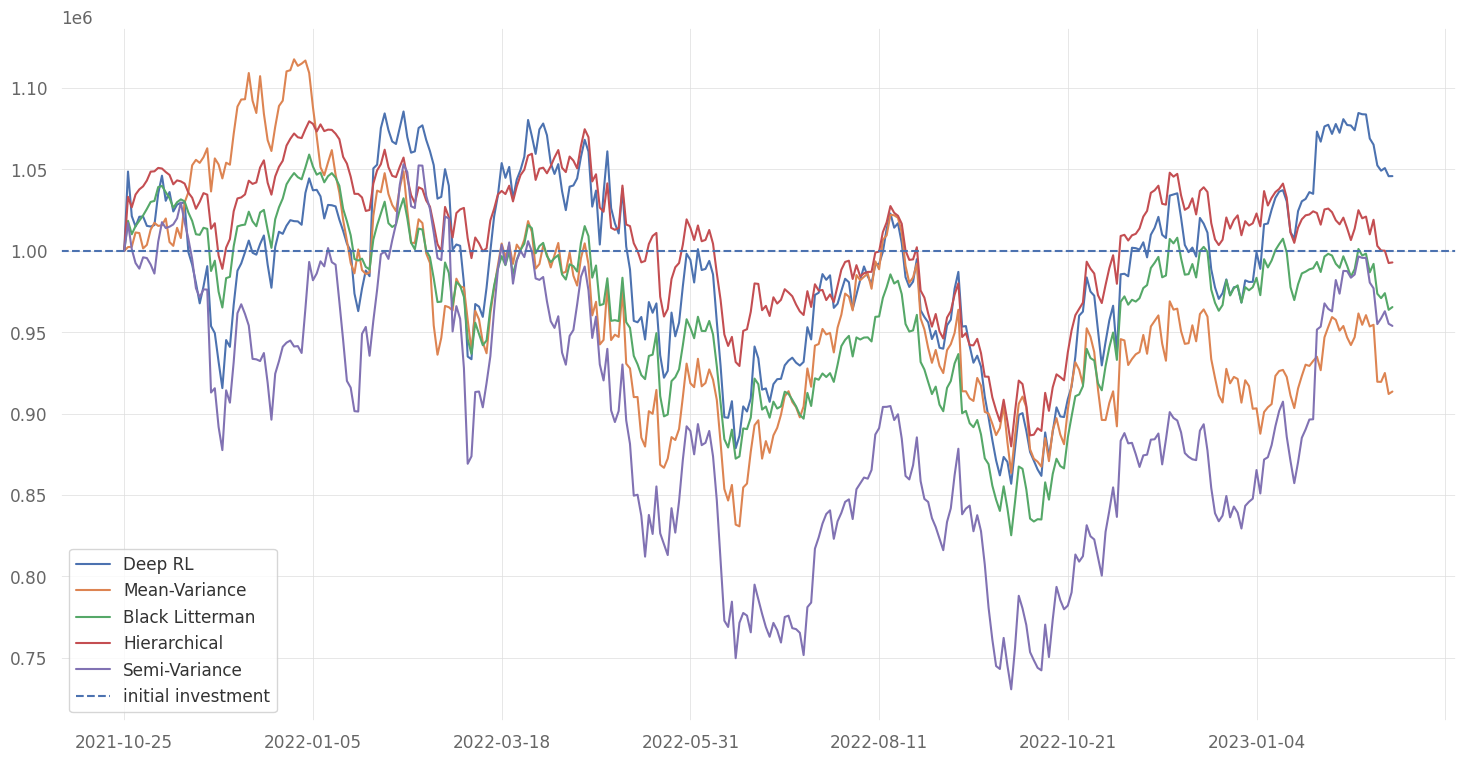

In [65]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (18,9)
plt.figure();
results.plot();
plt.axhline(1e6, 0, 1, linestyle='--', label="initial investment")
plt.legend()
plt.show()

In [66]:
print(qs.stats.sharpe(1 + (results - 1000000) / 1000000))

Deep RL            0.288841
Mean-Variance     -0.168368
Black Litterman   -0.053255
Hierarchical       0.047008
Semi-Variance      0.032121
dtype: float64


In [67]:
print(qs.stats.volatility(1 + (results - 1000000) / 1000000))

Deep RL            0.242933
Mean-Variance      0.236183
Black Litterman    0.182369
Hierarchical       0.161033
Semi-Variance      0.300192
dtype: float64


In [68]:
print(qs.stats.expected_return(results) * 100)

Deep RL            0.016310
Mean-Variance     -0.026833
Black Litterman   -0.010441
Hierarchical      -0.002129
Semi-Variance     -0.014023
dtype: float64
